In [1]:
import dgl
from sklearn.neighbors import kneighbors_graph
import numpy as np
import pandas as pd
import torch
import pickle
from tqdm import trange
import histocartography
import matplotlib.pyplot as plt
import copy

Using backend: pytorch


In [2]:
DATA_PATH = './data/'

In [3]:
pt_data = pd.read_excel(DATA_PATH+'CRC_TMAs_patient_annotations.xlsx')
df = pd.read_csv(DATA_PATH+'CRC_master.csv')

/home/joeleliason/anaconda3/envs/hactnet/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [4]:
labs, ids = np.unique(df.loc[:,'ClusterName'].to_numpy(), return_inverse=True)
df['ClusterID'] = ids

In [5]:
df.head()

,Unnamed: 0,CellID,patients,spots,groups,ClusterName,size,CD44 - stroma,FOXP3 - regulatory T cells,CD8 - cytotoxic T cells,...,CD8+ICOS+,CD8+Ki67+,CD8+PD-1+,Treg-ICOS+,Treg-Ki67+,Treg-PD-1+,X,Y,Z,ClusterID
0,0,0,1,1_A,1,granulocytes,10120,1.843591,17.398706,0.000000,...,0,0,0,0,0,0,77,589,10,17
1,1,1,1,1_A,1,granulocytes,861,30.284525,18.375738,74.695236,...,0,0,0,0,0,0,106,826,10,17
2,2,2,1,1_A,1,granulocytes,6206,139.488510,249.746979,85.556976,...,0,0,0,0,0,0,107,545,10,17
3,3,3,1,1_A,1,granulocytes,6320,20.596886,81.759758,0.000000,...,0,0,0,0,0,0,98,564,10,17
4,4,4,1,1_A,1,granulocytes,1591,67.328728,122.195473,11.028284,...,0,0,0,0,0,0,217,329,10,17


In [54]:
k = 5
thresh = 50
LABEL = "label"
CENTROID = "centroid"
FEATURES = "feat"
graphs = []
patients = []
for graph_id,spot in enumerate(df['spots'].unique()):
    subset = df.loc[df.loc[:,'spots'] == spot,:]
    features = subset.loc[:,'size':'Treg-PD-1+'].to_numpy() # np.ndarray, shape(n_nodes,n_feats)
    centroids = subset.loc[:,'X':'Y'].to_numpy() # np.ndarray, shape(n_nodes,2)
    cell_ids = subset.loc[:,'CellID'].to_numpy()
    # ,annotation = np.unique(subset.loc[:,'ClusterName'].to_numpy(), return_inverse=True) # np.ndarray, shape(n_nodes,)
    annotation = subset.loc[:,'ClusterID'].to_numpy() # np.ndarray, shape(n_nodes,)
    num_nodes = features.shape[0]
    graph = dgl.DGLGraph()
    graph.add_nodes(num_nodes)

    # add image size as graph data
    # image_size = (instance_map.shape[1], instance_map.shape[0])  # (x, y)

    # get instance centroids
    # centroids = self._get_node_centroids(instance_map)

    # add node content
    # self._set_node_centroids(centroids, graph)
    graph.ndata[CENTROID] = torch.FloatTensor(centroids)
    # self._set_node_features(features, image_size, graph)
    graph.ndata[FEATURES] = torch.FloatTensor(features)
    # graph.ndata[FEATURES] = torch.FloatTensor(annotation.astype(float)).unsqueeze(-1)

    if annotation is not None:
        graph.ndata[LABEL] = torch.FloatTensor(annotation.astype(float))
    graph.ndata['cell_ids'] = cell_ids
    graph.ndata['graph_id'] = np.array([graph_id for _ in range(num_nodes)])
    # build kNN adjacency
    adj = kneighbors_graph(
        centroids,
        k,
        mode="distance",
        include_self=False,
        metric="euclidean").toarray()

    # filter edges that are too far (ie larger than thresh)
    if thresh is not None:
        adj[adj > thresh] = 0

    edge_list = np.nonzero(adj)
    graph.add_edges(list(edge_list[0]), list(edge_list[1]))
    graphs.append(graph)
    patients.append(subset['patients'].unique()[0])

In [41]:
graphs[0]

DGLGraph(num_nodes=1164, num_edges=4376,
         ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'cell_ids': Scheme(shape=(), dtype=torch.int64), 'graph_id': Scheme(shape=(), dtype=torch.int64)}
         edata_schemes={})

In [42]:
targets = []
for pt in patients:
    cp = pt_data.loc[pt_data.loc[:,'Patient'] == pt,'cp_TNM_Simple'].values[0]
    t = 0 if cp == 3.0 else 1
    targets.append(t)

In [43]:
len(targets)

140

In [44]:
len(graphs)

140

In [55]:
data = list(zip(graphs,targets))

In [14]:
with open(DATA_PATH+'graphs_labels.pkl','wb') as f:
    pickle.dump([data,],f)

In [56]:
node_dim = data[0][0].ndata['feat'].shape[1]
# node_dim = 1

In [57]:
from torch.utils.data import DataLoader
import random

# 3. Batchify and train/val split the data
random.shuffle(data)
train_data = data[:int(len(data)* 0.7)]
val_data = data[int(len(data)*0.7):]
batch_size = 8

def collate(batch):
    g = dgl.batch([example[0] for example in batch])
    l = torch.LongTensor([example[1] for example in batch])
    return g, l

train_dataloader = DataLoader(data, batch_size, shuffle=True, collate_fn=collate)
val_dataloader = DataLoader(data, batch_size, collate_fn=collate)

In [48]:
gnn_params = {
    'readout_op': 'concat',
    'layer_type': 'gin_layer',
    'hidden_dim': 32,
    # 'agg_type': 'mean',
    'output_dim': 16,
    'num_layers': 2,
    'readout_type': 'mean',
    # 'with_lrp': False,
    'batch_norm': False,
    'act':'relu'
}
classification_params = {
    'hidden_dim': 32,
    'num_layers': 2
}

In [65]:
gnn_params = {'readout_op': 'concat',
 'layer_type': 'gin_layer',
 'hidden_dim': 32,
 'agg_type': 'mean',
 'output_dim': 16,
 'num_layers': 2,
 'readout_type': 'mean',
 'batch_norm': True,
 'act': 'relu'}
classification_params = {
    'hidden_dim': 16,
    'num_layers': 3
}

In [285]:
all_gnn_params = {
    'readout_op': ['concat','none'],
    'layer_type': ['gin_layer','pna_layer'],
    'hidden_dim': [16,32,64,128],
    'agg_type': ['mean'], # also other agg_types
    'output_dim': [16,32,64],
    'num_layers': [2,3],
    'readout_type': ['mean'], # also sum, max, min
    'batch_norm': [True,False],
    'act': ['relu']
}
all_classification_params = {
    'hidden_dim': [16,32,64,128],
    'num_layers': [2,3]
}

In [59]:
import importlib
importlib.reload(histocartography)
from histocartography.ml import CellGraphModel

In [63]:
cgm = CellGraphModel(gnn_params,classification_params,node_dim,num_classes = 2)

In [64]:
import torch
from tqdm import trange

# build optimizer
optimizer = torch.optim.Adam(
    cgm.parameters(),
    lr=10e-3,
    weight_decay=5e-4
)

# define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# training 
val_loss = 10e5
val_accuracy = 0.

with trange(50) as t:
    for epoch in t:
        t.set_description('Validation with loss={} | accuracy={}'.format(val_loss, val_accuracy))
        # A.) train for 1 epoch 
        cgm.train()
        for gs, ls in train_dataloader:

            # 1. forward pass
            logits = cgm(gs)

            # 2. backward pass
            loss = loss_fn(logits, ls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        cgm.eval()
        all_val_logits = []
        all_val_labels = []
        for gs, ls in val_dataloader:
            with torch.no_grad():
                logits = cgm(gs)
            all_val_logits.append(logits)
            all_val_labels.append(ls)

        all_val_logits = torch.cat(all_val_logits).cpu()
        all_val_labels = torch.cat(all_val_labels).cpu()

        with torch.no_grad():
            val_loss = round(loss_fn(all_val_logits, all_val_labels).item(), 2)
            _, predictions = torch.max(all_val_logits, dim=1)
            correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
            val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)

Validation with loss=0.18 | accuracy=0.9: 100%|█| 50/50 [03:01<00:00,  3.64s/it]


In [258]:
cgm.cell_graph_gnn

MultiLayerGNN(
  (layers): ModuleList(
    (0): GINLayer(
      (mlp): MLP(
        (activation): ReLU()
        (mlp): ModuleList(
          (0): Sequential(
            (fc): Linear(in_features=74, out_features=32, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (relu): ReLU()
          )
          (1): Sequential(
            (fc): Linear(in_features=32, out_features=16, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (1): GINLayer(
      (mlp): MLP(
        (activation): ReLU()
        (mlp): ModuleList(
          (0): Sequential(
            (fc): Linear(in_features=16, out_features=32, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (relu): ReLU()
          )
          (1): Sequential(
            (fc): Linear(in_features=32, out_features=16, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
  )
)

In [259]:
predictions == all_val_labels

tensor([ True,  True,  True, False,  True, False,  True,  True, False, False,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True, False,  True,  True,  True,
        False, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
        False,  True,  True, False,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True,  True, False,  True, False, False,
         True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [264]:
torch.save(cgm.state_dict(), DATA_PATH+'cgm_params.cpt')

In [265]:
with open(DATA_PATH+'cgm.pkl','wb') as f:
    pickle.dump(cgm,f)

In [179]:
with open(DATA_PATH+'cgm.pkl','rb') as f:
    cgm = pickle.load(f)

In [266]:
# import histocartography
import importlib
importlib.reload(histocartography)
from histocartography.interpretability import (
    GraphPruningExplainer,
    GraphGradCAMExplainer,
    GraphGradCAMPPExplainer,
    GraphLRPExplainer
)
grad_campp_explainer = GraphGradCAMPPExplainer(model=cgm)
grad_cam_explainer = GraphGradCAMExplainer(model=cgm)
lrp_explainer = GraphLRPExplainer(model=cgm)
pruning_explainer = GraphPruningExplainer(model=cgm)

In [267]:
importance_scores_grad_campp = []
importance_scores_grad_cam = []
# importance_scores_pruning = []
for e in data:
    graph = e[0]
    importance_scores_grad_campp.append(grad_campp_explainer.process(graph)[0])
    importance_scores_grad_cam.append(grad_cam_explainer.process(graph)[0])
    # importance_scores_pruning.append(pruning_explainer.process(graph)[0])
    
with open(DATA_PATH+'importance_scores.pkl','wb') as f:
    pickle.dump({'grad_campp': importance_scores_grad_campp,
                 'grad_cam': importance_scores_grad_cam,
                  'graphs': graphs,
                  'model': cgm},f)

In [269]:
with open(DATA_PATH+'cluster_ids.pkl','wb') as f:
    pickle.dump({'labs':labs,
                'ids':ids},f)

In [270]:
labs

array(['B cells', 'CD11b+ monocytes', 'CD11b+CD68+ macrophages',
       'CD11c+ DCs', 'CD163+ macrophages', 'CD3+ T cells', 'CD4+ T cells',
       'CD4+ T cells CD45RO+', 'CD4+ T cells GATA3+', 'CD68+ macrophages',
       'CD68+ macrophages GzmB+', 'CD68+CD163+ macrophages',
       'CD8+ T cells', 'NK cells', 'Tregs', 'adipocytes', 'dirt',
       'granulocytes', 'immune cells', 'immune cells / vasculature',
       'lymphatics', 'nerves', 'plasma cells', 'smooth muscle', 'stroma',
       'tumor cells', 'tumor cells / immune cells', 'undefined',
       'vasculature'], dtype=object)

In [281]:
cgm.eval()
scores_labels = []
for score_campp,score_cam,e in zip(importance_scores_grad_campp,
                                        importance_scores_grad_cam,
                                        data):
    graph = e[0]
    # print(graph)
    target = e[1]
    # print(target)
    with torch.no_grad():
        c = copy.deepcopy(graph)
        logits = cgm(c)
        pred = torch.argmax(logits)
    l = graph.ndata['label'].numpy()
    pos = graph.ndata['centroid'].numpy()
    l = [labs[int(i)] for i in l]
    d = pd.DataFrame({'cell_type':l,'score_campp':score_campp,'score_cam':score_cam,'X':pos[:,0],'Y':pos[:,1]})
    d.attrs['stage'] = 3.0 if target == 0 else 4.0
    d.attrs['pred'] = 3.0 if pred == 0 else 4.0
    scores_labels.append(d)

In [282]:
scores_labels[0].attrs

{'stage': 3.0, 'pred': 3.0}

In [283]:
predictions

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
scl = scores_labels[0]

NameError: name 'scores_labels' is not defined

In [158]:
graphs[0]

DGLGraph(num_nodes=1164, num_edges=4376,
         ndata_schemes={'centroid': Scheme(shape=(2,), dtype=torch.float32), 'feat': Scheme(shape=(64,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'gnn_agg_msg': Scheme(shape=(64,), dtype=torch.float32), 'gnn_node_feat_out': Scheme(shape=(64,), dtype=torch.float32)}
         edata_schemes={})

In [169]:
cgm

CellGraphModel(
  (cell_graph_gnn): MultiLayerGNN(
    (layers): ModuleList(
      (0): GINLayer(
        (mlp): MLP(
          (activation): ReLU()
          (mlp): ModuleList(
            (0): Sequential(
              (fc): Linear(in_features=74, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relu): ReLU()
            )
            (1): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
        )
      )
      (1): GINLayer(
        (mlp): MLP(
          (activation): ReLU()
          (mlp): ModuleList(
            (0): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relu): ReLU()
            )
            (1): Sequential(
              (fc): Linear(in_features=64, out_features=64, bias=True)
              (dropout): D

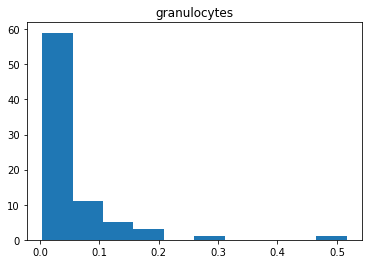

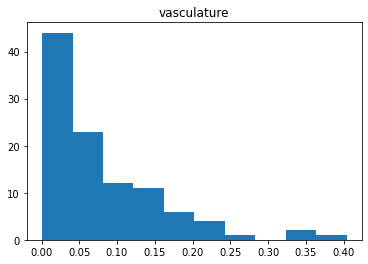

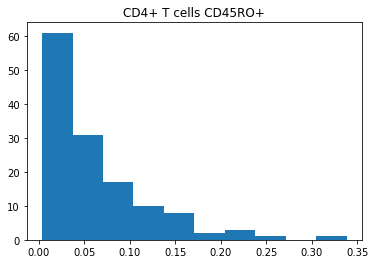

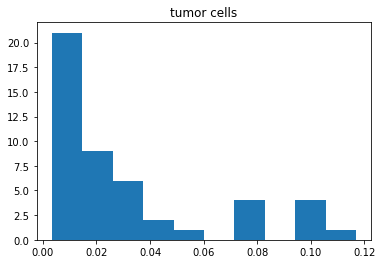

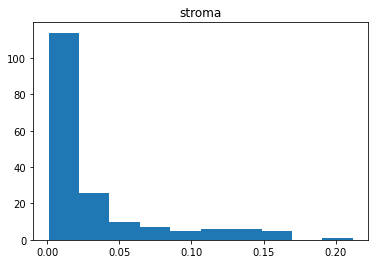

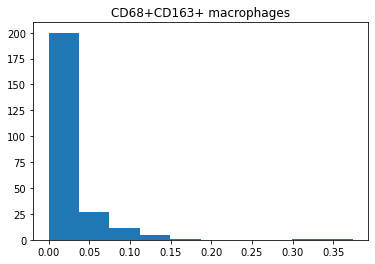

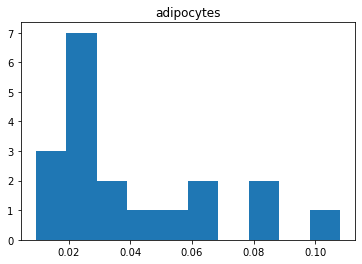

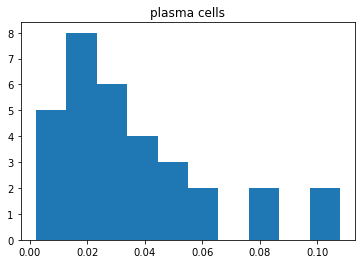

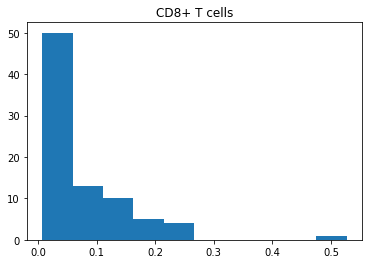

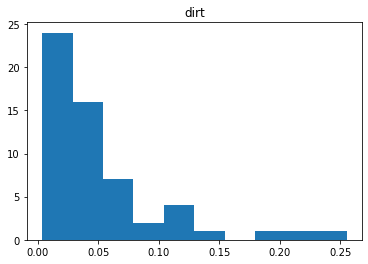

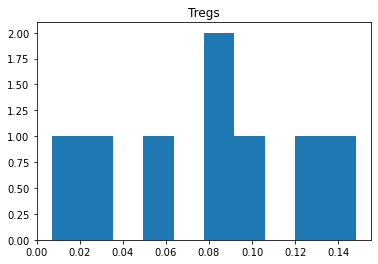

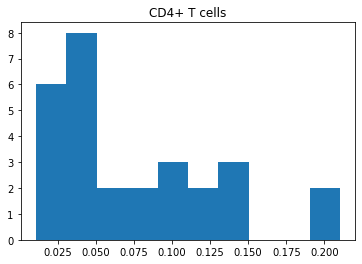

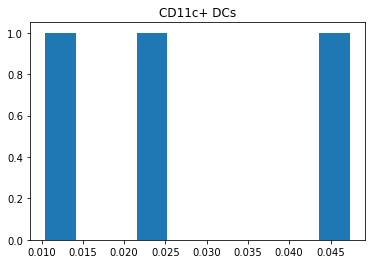

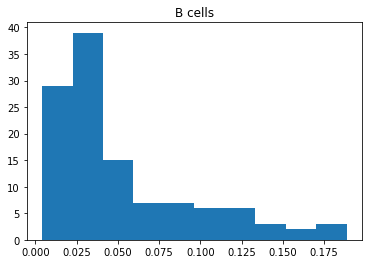

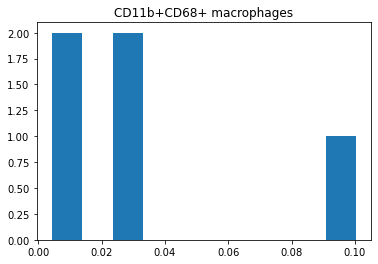

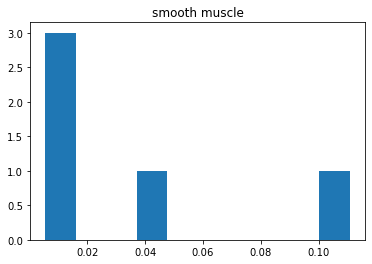

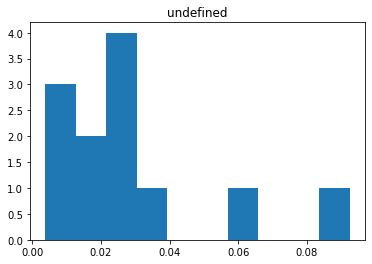

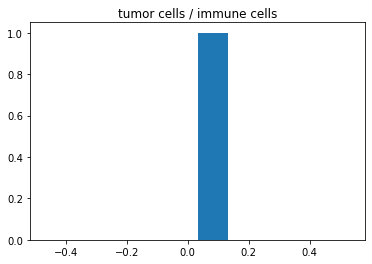

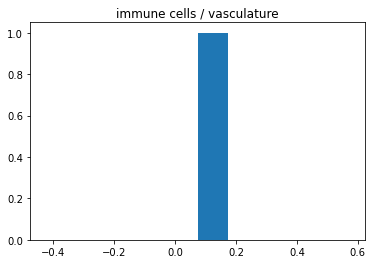

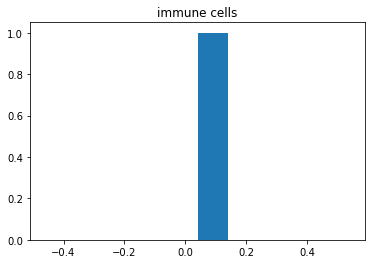

In [92]:
# plot histogram of scores per cell type
for ct in scl.cell_type.unique():
    plt.hist(scl[scl['cell_type'] == ct].score_campp)
    plt.title(ct)
    plt.show()

In [16]:
# Look at cell type composition of top 100 contributing cells
scl.sort_values('score_campp',ascending=False).cell_type[:100].value_counts()

NameError: name 'scl' is not defined

In [93]:
scl.sort_values('score_cam',ascending=False).cell_type.loc[:100].value_counts()

vasculature                   42
CD4+ T cells CD45RO+          40
B cells                       28
stroma                        26
CD8+ T cells                  26
granulocytes                  17
CD68+CD163+ macrophages       16
dirt                          15
CD4+ T cells                  11
tumor cells                    7
Tregs                          5
plasma cells                   4
adipocytes                     1
immune cells / vasculature     1
CD11b+CD68+ macrophages        1
smooth muscle                  1
undefined                      1
Name: cell_type, dtype: int64

In [94]:
scl = scores_labels[2]

In [95]:
scl.attrs

{'stage': 4.0}

In [96]:
scl.sort_values('score_campp',ascending=False).cell_type.loc[:100].value_counts()

smooth muscle                 168
CD68+CD163+ macrophages        74
vasculature                    71
CD8+ T cells                   51
tumor cells                    51
CD4+ T cells CD45RO+           32
stroma                         29
dirt                           25
Tregs                          18
granulocytes                   15
plasma cells                   14
adipocytes                      6
undefined                       5
tumor cells / immune cells      4
CD4+ T cells                    4
immune cells / vasculature      4
immune cells                    3
CD68+ macrophages               2
nerves                          2
B cells                         1
CD11b+CD68+ macrophages         1
lymphatics                      1
Name: cell_type, dtype: int64

### Hyperparameter optimization

In [318]:
all_gnn_params = {
    'readout_op': ['concat','none','lstm'],
    'layer_type': ['pna_layer'], # also try pna_layer later
    # 'hidden_dim': [16,32,64,128],
    # 'agg_type': ['mean','min','max'], # also other agg_types
    'output_dim': [16,32,64],
    'num_layers': [2,3],
    'readout_type': ['sum','mean','min','max'], # also sum, max, min
    'batch_norm': [True,False],
    # 'act': ['relu']
}
all_classification_params = {
    'hidden_dim': [16,32,64,128],
    'num_layers': [2,3]
}

In [298]:
def random_params(params):
    r = {}
    for k,v in params.items():
        r[k] = random.choice(v)
    return r

In [307]:
import pprint
pp = pprint.PrettyPrinter()

In [308]:
pp.pprint(random_params(all_gnn_params))

{'act': 'relu',
 'agg_type': 'mean',
 'batch_norm': False,
 'hidden_dim': 32,
 'layer_type': 'gin_layer',
 'num_layers': 2,
 'output_dim': 32,
 'readout_op': 'none',
 'readout_type': 'mean'}


In [319]:
import random
import pprint
JOBS = 10
val_accuracies = []
NUM_EPOCHS = 50
num_jobs = 0

while num_jobs < JOBS:
    
    params_already_tested = True
    while params_already_tested:
        already_gnn_params = [d['gnn_params'] for d in val_accuracies]
        already_class_params = [d['classification_params'] for d in val_accuracies]
        gnn_params = random_params(all_gnn_params)
        classification_params = random_params(all_classification_params)
        params_already_tested = gnn_params in already_gnn_params or classification_params in already_class_params
        
    print('GNN params: \n')
    pp.pprint(gnn_params)
    print('\n')
    print('Classification params: \n')
    pp.pprint(classification_params)
    print('\n')
    
    # try:
    cgm = CellGraphModel(gnn_params,classification_params,node_dim,num_classes = 2)
    # except:
    #     # print('Parameter selection inconsistent. Trying new combination...')
    #     continue
    # build optimizer
    optimizer = torch.optim.Adam(
        cgm.parameters(),
        lr=10e-3,
        weight_decay=5e-4
    )

    # define loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # training 
    val_loss = 10e5
    val_accuracy = 0.

    with trange(NUM_EPOCHS) as t:
        for epoch in t:
            t.set_description('Validation with loss={} | accuracy={}'.format(val_loss, val_accuracy))
            # A.) train for 1 epoch 
            cgm.train()
            for gs, ls in train_dataloader:

                # 1. forward pass
                logits = cgm(gs)

                # 2. backward pass
                loss = loss_fn(logits, ls)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            cgm.eval()
            all_val_logits = []
            all_val_labels = []
            for gs, ls in val_dataloader:
                with torch.no_grad():
                    logits = cgm(gs)
                all_val_logits.append(logits)
                all_val_labels.append(ls)

            all_val_logits = torch.cat(all_val_logits).cpu()
            all_val_labels = torch.cat(all_val_labels).cpu()

            with torch.no_grad():
                val_loss = round(loss_fn(all_val_logits, all_val_labels).item(), 2)
                _, predictions = torch.max(all_val_logits, dim=1)
                correct = torch.sum(predictions.to(int) == all_val_labels.to(int))
                val_accuracy = round(correct.item() * 1.0 / len(all_val_labels), 2)
    val_accuracies.append({
        'model': copy.deepcopy(cgm),
        'gnn_params': copy.deepcopy(gnn_params),
        'classification_params': copy.deepcopy(classification_params),
        'total_accuracy': copy.deepcopy(val_accuracy)
    })
    num_jobs += 1

GNN params: 

{'batch_norm': False,
 'layer_type': 'pna_layer',
 'num_layers': 3,
 'output_dim': 32,
 'readout_op': 'concat',
 'readout_type': 'min'}


Classification params: 

{'hidden_dim': 32, 'num_layers': 2}




Validation with loss=0.54 | accuracy=0.76:   4%| | 2/50 [00:48<19:24, 24.27s/it]


KeyboardInterrupt: 